In [1]:
import pandas as pd

df = pd.read_csv('train-data.dat', sep=',', header=None)
df.columns = ['sentence']
df['sentence'] = df['sentence'].str.replace('<.*?>', '', regex=True)  # deletes <int>
# print(df.head())
df = df[0:1000]
df.head()

vocab = pd.read_csv('vocabs.txt', sep=',', header=None)
vocab.columns = ['word', 'id']

sentences = pd.read_csv('train-data.dat', sep=',', header=None)
sentences.head()

com = []
for line in df.sentence:
    sen = ''
    for word in line.split():
      for id in vocab.id:
        if int(word) == int(id):
          sen = sen + ' ' + str(vocab.word[id]) 
    # print(sen)
    com.append(sen)

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

tfidf_vectorizer = TfidfVectorizer(use_idf=True)
tfidf_vectors = tfidf_vectorizer.fit_transform(com)

tfidf = tfidf_vectors.todense()
# TFIDF of words not in the doc will be 0, so replace them with nan
tfidf[tfidf == 0] = np.nan
# Use nanmean of numpy which will ignore nan while calculating the mean
means = np.nanmean(tfidf, axis=0)
# convert it into a dictionary for later lookup
means = dict(zip(tfidf_vectorizer.get_feature_names(), means.tolist()[0]))

tfidf = tfidf_vectors.todense()
# Argsort the full TFIDF dense vector
ordered = np.argsort(tfidf*-1)
words = tfidf_vectorizer.get_feature_names()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [3]:
li = [[]]

for key in means:
  li.append([key, means[key]])

li.pop(0)
li[:5]

df2 = pd.DataFrame(li)
# df2 = df2.transpose()
df2.head()

tfidf_sc = df2[1]
print(tfidf_sc)

tfidf_len = len(tfidf_sc)
print(tfidf_len)

0       0.180064
1       0.105520
2       0.098096
3       0.163385
4       0.138688
          ...   
6848    0.110620
6849    0.151121
6850    0.124428
6851    0.184492
6852    0.223934
Name: 1, Length: 6853, dtype: float64
6853


In [4]:
# !pip install deap
import importlib.util

package_name = 'deap'

spec = importlib.util.find_spec(package_name)
if spec is None:
  !pip install deap
else:
  pass

import random
import matplotlib.pyplot as plt
from deap import base
from deap import creator
from deap import tools

POP_SIZE = 20
# P_CROSSOVER = 0.6
# P_MUTATION = 0.01
MAX_GENERATIONS = 10
GENERATIONS_EXIT = 3  # state the number of generations in which maxFitness remains the same,  for stopping condition


creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 160 kB 5.6 MB/s 


In [5]:
# tfidf_sc
df2.columns=['word', 'importance']
# print(df2.head(5))

def evaluation_function(individual):  

  sum = 0
  a = 0
  for i in individual:
    if i==1:
      a += df2.importance[i]
      sum += 1
  # a = a/sum

  counter = 0
  for i in individual:
    if i==1:
      counter+=1
  if counter<1000:
    a -= 50
  else:
    pass
  
  # a = a * 10000000000 - 10552039112682

  return a, 

In [6]:
tbx = base.Toolbox()

INDIVIDUAL_SIZE = tfidf_len

tbx.register("attr_bool", random.randint, 0, 1)
tbx.register('individual', tools.initRepeat, creator.Individual, tbx.attr_bool, INDIVIDUAL_SIZE)
tbx.register("population", tools.initRepeat, list, tbx.individual)

tbx.register("evaluate", evaluation_function)
tbx.register("select", tools.selTournament, tournsize=3)
tbx.register("mate", tools.cxUniform, indpb=0.5)
# tbx.register("mutate", tools.mutFlipBit, indpb=0.05)
tbx.register("mutate", tools.mutUniformInt, low=0, up=1, indpb=0.8)

In [7]:
def main():

  maxFitValues = []
  maxGenValues = []
  best_indx = []
  best = {}

  for i in range(10):
    print('Iteration {} --->'.format(i))
    pop = tbx.population(POP_SIZE)

    fitnesses = list(map(tbx.evaluate, pop))

    maxFitnessValues = []
    meanFitnessValues = []
    genbest = {}

    for ind, fit in zip(pop, fitnesses):
      ind.fitness.values = fit

    CXPB, MUTPB = 0.5, 0.2

    fits = [ind.fitness.values[0] for ind in pop]

    # Variable keeping track of the number of generations
    g = 0

    # Begin the evolution
    while g < MAX_GENERATIONS:
      #Stopping Conditions
      if g > GENERATIONS_EXIT and (
                    all(v == maxFitnessValues[len(maxFitnessValues) - 1] for v in maxFitnessValues[
                                                                                  (len(maxFitnessValues) - GENERATIONS_EXIT):len(maxFitnessValues)])):
        print("Stopping Conditions Occured.")
        break
      
      g = g + 1
      # print("-- Generation %i --" % g)

      # Select the next generation individuals
      offspring = tbx.select(pop, len(pop))
      # Clone the selected individuals
      offspring = list(map(tbx.clone, offspring))

      # Apply crossover and mutation on the offspring
      for child1, child2 in zip(offspring[::2], offspring[1::2]):
        if random.random() < CXPB:
          tbx.mate(child1, child2)
          del child1.fitness.values
          del child2.fitness.values

      for mutant in offspring:
        #Elitism - Elitist individuals do not get mutated
        if mutant != tools.selBest(offspring, 3, fit_attr="fitness"):
          if random.random() < MUTPB:
            tbx.mutate(mutant)
            del mutant.fitness.values

      # Evaluate the individuals with an invalid fitness
      invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
      fitnesses = map(tbx.evaluate, invalid_ind)
      for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

      #Replace the old population with the offspring
      pop[:] = offspring

      fitnessValues = [ind.fitness.values[0] for ind in pop]
      
      maxFitness = int(max(fitnessValues))
      meanFitness = int(sum(fitnessValues) / len(pop))
      maxFitnessValues.append(maxFitness)
      meanFitnessValues.append(meanFitness)
      print("- Generation {}: Max Fitness = {}, Avg Fitness = {}"
                  .format(g, maxFitness, meanFitness))
      
      best_index = fitnessValues.index(max(fitnessValues))

      # print(maxFitness, pop[best_index])
      genbest[maxFitness] = pop[best_index]

    maxGenValues.append(g)
    maxFitValues.append(max(maxFitnessValues))
    
    best.update(genbest)
   

  best = sorted(best.items())
  alpha = list(best)[-1]
  # print('Alpha Individual: ', alpha[1])


  print("Average Fitness of best individual is:", np.mean(maxFitValues))
  print("Best Fitness of best individual is:", np.amax(max(maxFitValues)))
  print("Average generation when stopping conditions are met:", np.mean(maxGenValues))
  plt.figure(0)
  plt.plot(maxFitnessValues, color='red')
  plt.plot(meanFitnessValues, color='green')
  plt.xlabel('Generation')
  plt.ylabel('Max / Average Fitness')
  plt.title('Max and Average fitness over Generations')
  plt.show()

  brain(alpha)
  return alpha

In [8]:
def brain(alpha):
  print(alpha[1])

In [9]:
X = []                                #creates bag of words array
for y in df.sentence:
  x_counter = [0] * 8519
  for w in y.split():
    for i in range(8520):
      if int(w) == i:
        x_counter[i] = x_counter[i] + 1
  X.append(x_counter)
X = pd.DataFrame(X) 
X

,0,1,2,3,4,5,6,7,8,9,...,8509,8510,8511,8512,8513,8514,8515,8516,8517,8518
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
# for i in alpha[1]:
# print(len(alpha[1]))

zero_indices = []
counter = 0
for i in alpha[1]:
  if i==0:
    zero_indices.append(counter)
  counter +=1

print(zero_indices)

X_short = pd.DataFrame()

for j in zero_indices:
  # print(X.columns[j])
  # X = X.drop(columns=X.columns[j], axis=1)
  X_short[j] = X[j]

X_short.shape()

[1, 3, 7, 8, 9, 12, 14, 16, 17, 18, 21, 23, 24, 25, 30, 31, 33, 35, 37, 41, 43, 44, 45, 50, 51, 56, 57, 58, 59, 62, 68, 72, 73, 76, 77, 80, 81, 82, 83, 84, 85, 89, 90, 93, 94, 95, 100, 101, 105, 106, 108, 112, 113, 114, 115, 116, 117, 118, 121, 124, 126, 128, 130, 132, 133, 136, 137, 138, 143, 148, 149, 155, 157, 159, 163, 164, 166, 167, 168, 170, 172, 174, 176, 180, 182, 184, 185, 188, 190, 193, 195, 198, 199, 200, 203, 205, 206, 207, 208, 209, 211, 212, 215, 223, 224, 229, 231, 234, 235, 236, 237, 244, 248, 250, 252, 254, 256, 257, 258, 259, 260, 263, 264, 266, 268, 269, 272, 275, 276, 278, 281, 283, 285, 287, 288, 289, 290, 296, 297, 300, 303, 304, 307, 310, 311, 312, 313, 314, 318, 319, 323, 324, 325, 326, 327, 328, 329, 333, 337, 339, 340, 341, 343, 348, 349, 362, 363, 367, 373, 374, 375, 378, 380, 381, 383, 384, 386, 388, 390, 392, 394, 395, 396, 397, 400, 401, 402, 404, 406, 410, 413, 416, 418, 422, 424, 425, 426, 427, 428, 434, 437, 440, 441, 442, 443, 444, 445, 448, 450, 452, 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


,1,3,7,8,9,12,14,16,17,18,...,6837,6840,6842,6843,6844,6847,6848,6849,6850,6851
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
y = pd.read_csv('train-label.dat', sep=',', header=None)       #reads output data
y.columns = ['label']       #names output data column
y = y[0:100]
y = y['label'].str.split(' ', expand=True)          #splits data into 20 columns
y = y.astype(int)       #makes output data integers
y

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,1,0,1,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
2,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,1,1,1,0,0,1,0,0,0,0,0,0,0
4,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
96,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0
97,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
98,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [20]:
import tensorflow as tf

X_short = tf.keras.utils.normalize(X_short, axis=1) 

In [29]:
X_short = X_short[:100]
X_short

,1,3,7,8,9,12,14,16,17,18,...,6837,6840,6842,6843,6844,6847,6848,6849,6850,6851
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.109109,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
96,0.0,0.0,0.0,0.0,0.0,0.109109,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
97,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
98,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Select number of hidden layer neurons:
	 1. equal to output neurons
	 2. equal to (output neurons + input neurons) / 2
	 3. equal to output neurons + input neurons
1

Epoch 1: binary_accuracy improved from -inf to 0.40857, saving model to best_m.h5

Epoch 2: binary_accuracy did not improve from 0.40857

Epoch 3: binary_accuracy improved from 0.40857 to 0.40857, saving model to best_m.h5

Epoch 4: binary_accuracy improved from 0.40857 to 0.41357, saving model to best_m.h5

Epoch 5: binary_accuracy improved from 0.41357 to 0.41786, saving model to best_m.h5

Epoch 6: binary_accuracy did not improve from 0.41786

Epoch 7: binary_accuracy improved from 0.41786 to 0.41929, saving model to best_m.h5

Epoch 8: binary_accuracy improved from 0.41929 to 0.42071, saving model to best_m.h5

Epoch 9: binary_accuracy improved from 0.42071 to 0.42500, saving model to best_m.h5

Epoch 10: binary_accuracy improved from 0.42500 to 0.42929, saving model to best_m.h5

Epoch 11: binary_accuracy improved fr

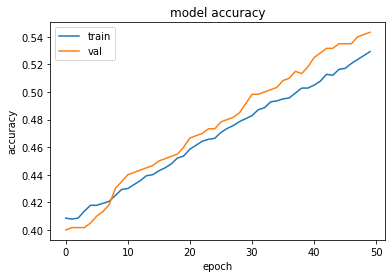


Epoch 1: binary_accuracy improved from -inf to 0.53643, saving model to best_m.h5

Epoch 2: binary_accuracy improved from 0.53643 to 0.54286, saving model to best_m.h5

Epoch 3: binary_accuracy improved from 0.54286 to 0.54643, saving model to best_m.h5

Epoch 4: binary_accuracy improved from 0.54643 to 0.55071, saving model to best_m.h5

Epoch 5: binary_accuracy improved from 0.55071 to 0.55214, saving model to best_m.h5

Epoch 6: binary_accuracy improved from 0.55214 to 0.55429, saving model to best_m.h5

Epoch 7: binary_accuracy improved from 0.55429 to 0.55643, saving model to best_m.h5

Epoch 8: binary_accuracy improved from 0.55643 to 0.55714, saving model to best_m.h5

Epoch 9: binary_accuracy improved from 0.55714 to 0.56143, saving model to best_m.h5

Epoch 10: binary_accuracy improved from 0.56143 to 0.56500, saving model to best_m.h5

Epoch 11: binary_accuracy improved from 0.56500 to 0.56643, saving model to best_m.h5

Epoch 12: binary_accuracy improved from 0.56643 to 0.5

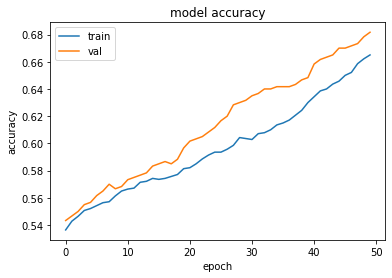


Epoch 1: binary_accuracy improved from -inf to 0.60643, saving model to best_m.h5

Epoch 2: binary_accuracy improved from 0.60643 to 0.61000, saving model to best_m.h5

Epoch 3: binary_accuracy improved from 0.61000 to 0.61286, saving model to best_m.h5

Epoch 4: binary_accuracy did not improve from 0.61286

Epoch 5: binary_accuracy improved from 0.61286 to 0.61643, saving model to best_m.h5

Epoch 6: binary_accuracy improved from 0.61643 to 0.61929, saving model to best_m.h5

Epoch 7: binary_accuracy improved from 0.61929 to 0.62143, saving model to best_m.h5

Epoch 8: binary_accuracy improved from 0.62143 to 0.62571, saving model to best_m.h5

Epoch 9: binary_accuracy improved from 0.62571 to 0.63071, saving model to best_m.h5

Epoch 10: binary_accuracy improved from 0.63071 to 0.63214, saving model to best_m.h5

Epoch 11: binary_accuracy improved from 0.63214 to 0.63429, saving model to best_m.h5

Epoch 12: binary_accuracy improved from 0.63429 to 0.63643, saving model to best_m.h5

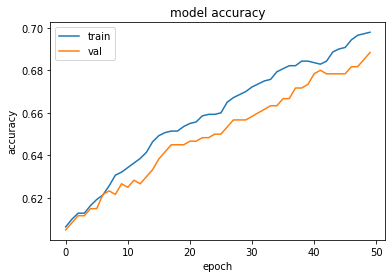


Epoch 1: binary_accuracy improved from -inf to 0.45857, saving model to best_m.h5

Epoch 2: binary_accuracy improved from 0.45857 to 0.46000, saving model to best_m.h5

Epoch 3: binary_accuracy improved from 0.46000 to 0.46571, saving model to best_m.h5

Epoch 4: binary_accuracy improved from 0.46571 to 0.46643, saving model to best_m.h5

Epoch 5: binary_accuracy improved from 0.46643 to 0.46786, saving model to best_m.h5

Epoch 6: binary_accuracy improved from 0.46786 to 0.46857, saving model to best_m.h5

Epoch 7: binary_accuracy improved from 0.46857 to 0.47000, saving model to best_m.h5

Epoch 8: binary_accuracy improved from 0.47000 to 0.47357, saving model to best_m.h5

Epoch 9: binary_accuracy improved from 0.47357 to 0.47786, saving model to best_m.h5

Epoch 10: binary_accuracy improved from 0.47786 to 0.48214, saving model to best_m.h5

Epoch 11: binary_accuracy improved from 0.48214 to 0.48286, saving model to best_m.h5

Epoch 12: binary_accuracy improved from 0.48286 to 0.4

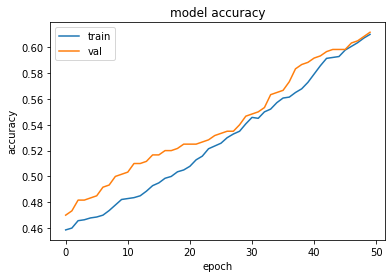


Epoch 1: binary_accuracy improved from -inf to 0.51857, saving model to best_m.h5

Epoch 2: binary_accuracy improved from 0.51857 to 0.52000, saving model to best_m.h5

Epoch 3: binary_accuracy did not improve from 0.52000

Epoch 4: binary_accuracy improved from 0.52000 to 0.52500, saving model to best_m.h5

Epoch 5: binary_accuracy improved from 0.52500 to 0.52714, saving model to best_m.h5

Epoch 6: binary_accuracy improved from 0.52714 to 0.53071, saving model to best_m.h5

Epoch 7: binary_accuracy improved from 0.53071 to 0.53214, saving model to best_m.h5

Epoch 8: binary_accuracy improved from 0.53214 to 0.53429, saving model to best_m.h5

Epoch 9: binary_accuracy improved from 0.53429 to 0.53643, saving model to best_m.h5

Epoch 10: binary_accuracy improved from 0.53643 to 0.53714, saving model to best_m.h5

Epoch 11: binary_accuracy improved from 0.53714 to 0.53929, saving model to best_m.h5

Epoch 12: binary_accuracy did not improve from 0.53929

Epoch 13: binary_accuracy imp

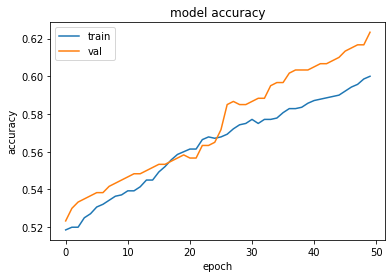

In [32]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Conv2D, MaxPool2D
from keras import regularizers
from keras import backend as K
import tensorflow as tf
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import numpy as np
from tensorflow import keras
from keras.optimizers import *
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from matplotlib import pyplot as plt


kfold = KFold(n_splits=5, shuffle=True)
rmseList = []

X_train, X_test, y_train, y_test = train_test_split(X_short, y, test_size=0.3, random_state=42)       #splits data into train, test

hl_n = 0
answer = input('Select number of hidden layer neurons:\n\t 1. equal to output neurons\n\t '
  '2. equal to (output neurons + input neurons) / 2\n\t 3. equal to output neurons + input neurons\n')
if answer == '1':
  hl_n = 20                   #hidden layer neurons number
elif answer == '2':
  hl_n = int((20 + 3223) / 2)
elif answer == '3':
  hl_n = 3223

# hl_n2 = 0             #SECOND hidden layer neurons number
# answer2 = input('Select number of the SECOND hidden layer neurons:\n\t 1. equal to first hidden layer\n\t '
#                 '2. equal to (output neurons + input neurons) / 4\n\t 3. equal to output neurons\n')
# if answer2 == '1':
#     hl_n2 = int((20 + 3223) / 2)
# elif answer2 == '2':
#     hl_n2 = int((20 + 3223) / 4)
# elif answer2 == '3':
#     hl_n2 = 20

# opt = keras.optimizers.Adam(learning_rate=0.01)                   #adam
opt = keras.optimizers.SGD(learning_rate=0.001, momentum=0.2)       #sgd

for i, (train, test) in enumerate(kfold.split(X)):
  model = Sequential()
  # model.add(Dense(3223, input_shape=(3223,), activation='softmax', kernel_regularizer=regularizers.l2(0.1)))      #kernel l2 regulirization
  model.add(Dense(3223, input_shape=(3223,), activation='relu'))          #input
  model.add(Dense(hl_n, activation='relu'))                       #hidden
  # model.add(Dense(hl_n2, activation='relu'))                         #2nd hidden
  model.add(Dense(20, activation='sigmoid'))                      #output

  model.compile(
  optimizer=opt,
  loss='binary_crossentropy',
  # loss='mean_squared_error',
  # metrics=[rmse]
  metrics=['binary_accuracy']
  )

  es = EarlyStopping(             #early stopping
      monitor='val_loss',
      patience=5,
      verbose=0,
      mode='min'
  )

  mc = ModelCheckpoint(       #model checkpoint to save best model each epoch
      'best_m.h5',
      monitor='binary_accuracy',
      mode='max',
      verbose=1,
      save_best_only=True
  )

  history = model.fit(X_train, y_train,           #model fit
            validation_data=(X_test, y_test),
            epochs=50,
            callbacks=[es, mc],
            verbose=0)

  print('val_loss, val_acc: ', model.evaluate(X_test, y_test), sep='')        #model evaluation

  scores = model.evaluate(X_test, y_test, verbose=0)
  rmseList.append(scores[0])
  print("Fold :", i+1, " loss", scores[0])

  plt.plot(history.history['binary_accuracy'])            #plots accuracy, val_accuracy/epoch graph
  plt.plot(history.history['val_binary_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

Iteration 0 --->
- Generation 1: Max Fitness = 373, Avg Fitness = 365
- Generation 2: Max Fitness = 374, Avg Fitness = 367
- Generation 3: Max Fitness = 374, Avg Fitness = 367
- Generation 4: Max Fitness = 374, Avg Fitness = 369
Stopping Conditions Occured.
Iteration 1 --->
- Generation 1: Max Fitness = 373, Avg Fitness = 366
- Generation 2: Max Fitness = 373, Avg Fitness = 367
- Generation 3: Max Fitness = 375, Avg Fitness = 370
- Generation 4: Max Fitness = 379, Avg Fitness = 371
- Generation 5: Max Fitness = 381, Avg Fitness = 374
- Generation 6: Max Fitness = 381, Avg Fitness = 377
- Generation 7: Max Fitness = 383, Avg Fitness = 377
- Generation 8: Max Fitness = 381, Avg Fitness = 378
- Generation 9: Max Fitness = 382, Avg Fitness = 375
- Generation 10: Max Fitness = 382, Avg Fitness = 377
Iteration 2 --->
- Generation 1: Max Fitness = 369, Avg Fitness = 365
- Generation 2: Max Fitness = 370, Avg Fitness = 367
- Generation 3: Max Fitness = 372, Avg Fitness = 368
- Generation 4: Ma

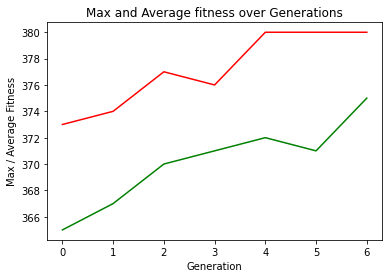

[1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 

In [10]:
alpha = main()